In [29]:
from transformers import BertTokenizer, BertModel

path = './bert-base-uncased/'

tokenizer_bert = BertTokenizer.from_pretrained(path)
text = "伊朗再打以色列"
encoded_input = tokenizer_bert(text, return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[ 101, 1762,  100,  100,  100,  100,  100,  100,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [18]:
tokenizer_bert.tokenize(text)

['伊', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]']

In [62]:
from transformers import GPT2Tokenizer
path = './pt2/'
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(path)
text = "hello,world"
encoded_input = tokenizer_gpt2(text, return_tensors='pt')
print(encoded_input)
print(tokenizer_gpt2.tokenize(text))
[i for i in tokenizer_gpt2.tokenize(text)]


{'input_ids': tensor([[31373,    11,  6894]]), 'attention_mask': tensor([[1, 1, 1]])}
['hello', ',', 'world']


['hello', ',', 'world']

In [14]:
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show
from bertviz import head_view
path = './pt2/'
tokenizer = GPT2Tokenizer.from_pretrained(path)
model = GPT2Model.from_pretrained(path)
text = "An apple falls from the tree."
show(model, 'gpt2',tokenizer, text)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import re, collections
 
def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs
 
def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out
 
def build_vocab(text):
    counter = collections.defaultdict(int)
    for line in text:
        words = line.split()
        for word in words:
            counter[word] += 1
    return {" ".join(key) + " </w>": value for key, value in counter.items()}
 
# 示例文本
test_corpus = "new newer lower news"
 
vocab = build_vocab(test_corpus.split('\n'))
num_merges = 4
for i in range(num_merges):
    pairs = get_stats(vocab)
    print(pairs)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)
 
print(vocab)

defaultdict(<class 'int'>, {('n', 'e'): 3, ('e', 'w'): 3, ('w', '</w>'): 1, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('l', 'o'): 1, ('o', 'w'): 1, ('w', 's'): 1, ('s', '</w>'): 1})
defaultdict(<class 'int'>, {('ne', 'w'): 3, ('w', '</w>'): 1, ('w', 'e'): 2, ('e', 'r'): 2, ('r', '</w>'): 2, ('l', 'o'): 1, ('o', 'w'): 1, ('w', 's'): 1, ('s', '</w>'): 1})
defaultdict(<class 'int'>, {('new', '</w>'): 1, ('new', 'e'): 1, ('e', 'r'): 2, ('r', '</w>'): 2, ('l', 'o'): 1, ('o', 'w'): 1, ('w', 'e'): 1, ('new', 's'): 1, ('s', '</w>'): 1})
defaultdict(<class 'int'>, {('new', '</w>'): 1, ('new', 'er'): 1, ('er', '</w>'): 2, ('l', 'o'): 1, ('o', 'w'): 1, ('w', 'er'): 1, ('new', 's'): 1, ('s', '</w>'): 1})
{'new </w>': 1, 'new er</w>': 1, 'l o w er</w>': 1, 'new s </w>': 1}


## embedding

In [9]:
import torch
embedding = torch.nn.Embedding(1000,64)
t1 = torch.tensor(999)#代表一个token,
embedding(t1).shape

torch.Size([64])

$$
PE_{(pos,2i)} = sin(pos/10000^{\frac{2i}{d_{model}}})
$$
$$
PE_{(pos,2i+1)} = cos(pos/10000^{\frac{2i}{d_{model}}})
$$

### GELU


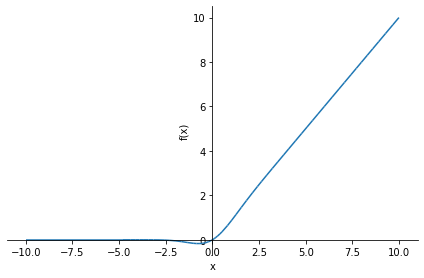

In [4]:
import sympy
x = sympy.symbols('x')
gelu =  0.5 * x * (1.0 + sympy.tanh(sympy.sqrt(2.0 / sympy.pi) * (x + 0.044715 * x**3)))
sympy.plot(gelu)

### 带T的softmax

In [7]:
import torch
t = torch.tensor([1.0,0.5,2.3,0.09])
y1 = torch.nn.functional.softmax(t)
y2 = torch.nn.functional.softmax(t/0.5)
y3 = torch.nn.functional.softmax(t/2)
y1,y2,y3

<ipython-input-7-683882d1f293>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y1 = torch.nn.functional.softmax(t)
<ipython-input-7-683882d1f293>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y2 = torch.nn.functional.softmax(t/0.5)
<ipython-input-7-683882d1f293>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y3 = torch.nn.functional.softmax(t/2)


(tensor([0.1761, 0.1068, 0.6462, 0.0709]),
 tensor([0.0667, 0.0245, 0.8980, 0.0108]),
 tensor([0.2310, 0.1799, 0.4425, 0.1466]))

In [57]:
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")
text = '以色列再打伊朗'
res = enc.encode(text)
print(res)
b1 = [enc.decode_single_token_bytes(i) for i in res]
# To get the tokeniser corresponding to a specific model in the OpenAI API:
b2 = [i.encode('utf-8') for i in text]
[enc.decode([i]) for i in res]

[23897, 39135, 32218, 88356, 76537, 17885, 232, 4916, 245]


['以', '色', '列', '再', '打', '�', '�', '�', '�']

### chatGLM

In [49]:
from transformers import AutoTokenizer, AutoConfig
 

model_name = "./chatglm2-6b/"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
text = "伊朗再打以色列"
tokens = tokenizer.encode(text)
print("tokens:", tokens)
[tokenizer.decode(i) for i in tokens]

tokens: [64790, 64792, 30910, 36372, 54860, 54819, 36415]


['', '', '', '伊朗', '再', '打', '以色列']